### Breast Cancer classifier


This project aims to classify breast tumors as malignant (cancerous) or benign (non-cancerous) using the Breast Cancer Wisconsin dataset from scikit-learn.  

We applied machine learning models, including Naïve Bayes and K-Nearest Neighbors (KNN) with 3 and 10 neighbors, to evaluate classification performance.  

The models were assessed using confusion matrix, ROC curve, cumulative response, and lift curve to ensure accurate and reliable predictions for early  detection.

##### Positive class (1) → Benign (Non-cancerous)

##### Negative class (0) → Malignant (Cancerous)in.  
.

#### Import Libraries

In [51]:
import numpy as np
from sklearn import (naive_bayes,neighbors,metrics, model_selection as skms,datasets,dummy)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


##### Import the data

bcancer = datasets.load_breast_cancer()

In [52]:
df = pd.DataFrame(bcancer.data,columns = bcancer.feature_names)
df['Target'] = bcancer.target
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,Target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


#### Classifiers

In [53]:
classifiers = {
    'base':dummy.DummyClassifier(strategy="most_frequent"),
    'gnb':naive_bayes.GaussianNB(),
    '3-NN':neighbors.KNeighborsClassifier(n_neighbors = 3),
    '10-NN':neighbors.KNeighborsClassifier(n_neighbors = 10)
    }

#### Assign target == 1 ie 1 → Benign (non-cancerous) in a variable

In [62]:
bcancer_tgt = bcancer.target == 1

#### Let's Select the measures

In [54]:
msrs = msrs = ['accuracy','average_precision','roc_auc']

#### Measures Vs Folds

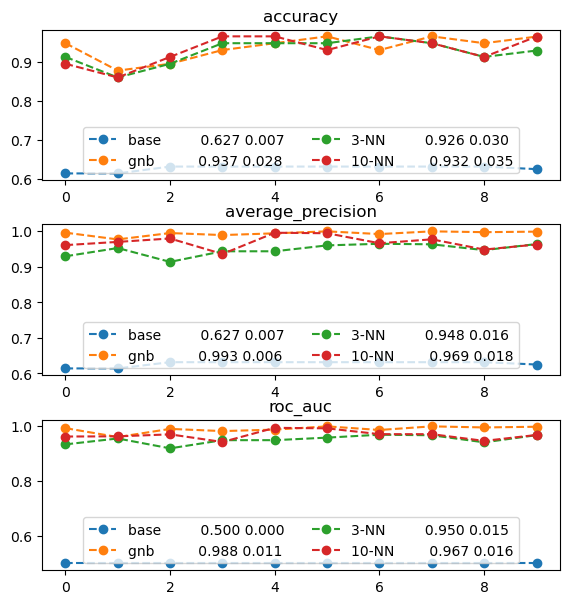

In [63]:
fig, axes, = plt.subplots(len(msrs),1,figsize=(6,2*len(msrs) ))
fig.tight_layout()

for model_name, model in classifiers.items():
    cv_score = skms.cross_val_score
    cv_result  = {msr:cv_score(model,bcancer.data, bcancer_tgt,scoring=msr,cv=10) for msr in msrs}

    for ax, msr in zip(axes,msrs):
        msr_result = cv_result[msr]
        mylabels = "{:12s} {:.3f} {:.3f}".format(model_name,msr_result.mean(),msr_result.std())
        ax.plot(msr_result,'o--',label=mylabels)
        ax.set_title(msr)
        ax.legend(loc='lower center',ncol=2)

#### Confusion Matrix

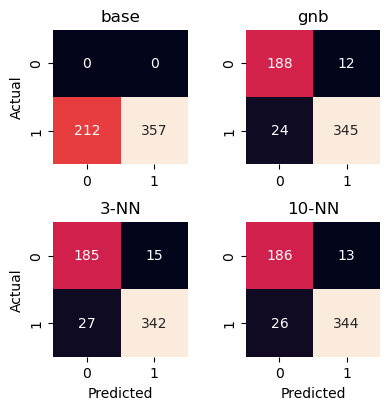

In [64]:
fig, axes = plt.subplots(2,2,figsize=(4,4))
fig.tight_layout()

for ax,(mod_name,model) in zip(axes.flat,classifiers.items()):
    preds = skms.cross_val_predict(model,bcancer.data,bcancer_tgt,cv = 10)
    cm = metrics.confusion_matrix(preds,bcancer.target == 1)

    sns.heatmap(cm,annot=True,square=True,ax=ax,cbar=False,fmt = "d")

    ax.set_title(mod_name)
axes[1,0].set_xlabel("Predicted")
axes[1,1].set_xlabel("Predicted")
axes[0,0].set_ylabel("Actual")
axes[1,0].set_ylabel("Actual")
plt.show()


##### The Baseline performs  terribly whereas other classifiers perform mildly better with some True negatives and False positives

#### ROC Curve

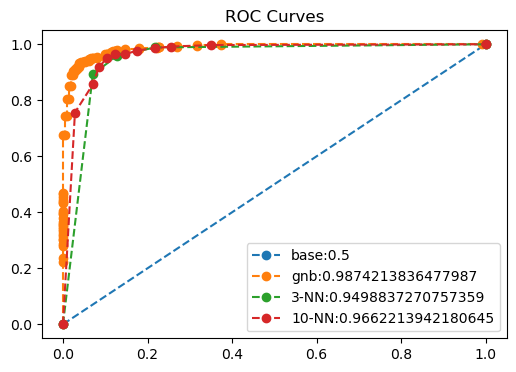

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

cv_prob_true = {}
for mod_name, model in classifiers.items():
    cv_probs = skms.cross_val_predict(model, 
                                      bcancer.data, bcancer_tgt, 
                                      cv=10, method='predict_proba')
    cv_prob_true[mod_name] = cv_probs[:,1]
    
    fpr, tpr, thresh = metrics.roc_curve(bcancer_tgt, 
                                         cv_prob_true[mod_name])
    
    auc = metrics.auc(fpr, tpr)
    ax.plot(fpr, tpr, 'o--', label="{}:{}".format(mod_name, auc))

ax.set_title('ROC Curves')
ax.legend();


##### The Area under ROC is the best for Gaussian Naive bayes followed by similar performance for other classifier but the baseline classifier is good as a random guess.

#### Cumulative Response and Lift Curves

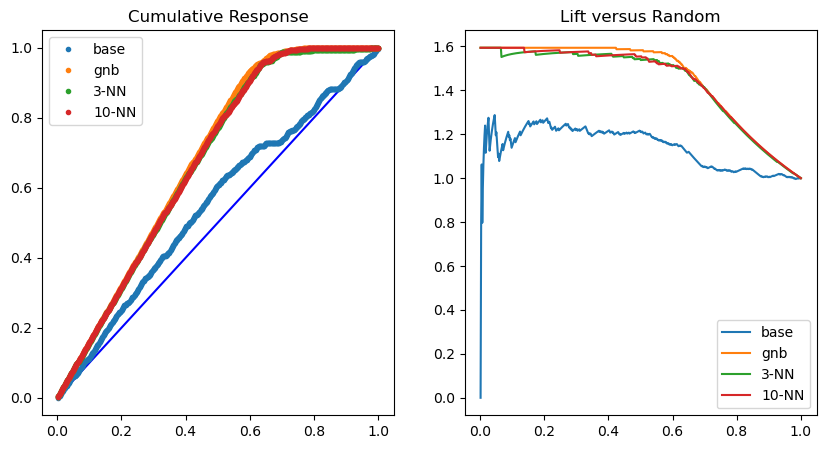

In [67]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10,5))

N = len(bcancer_tgt)
xs = np.linspace(1/N,1,N)

ax1.plot(xs, xs, 'b-')

for mod_name in classifiers:    
    # negate b/c we want big values first
    myorder = np.argsort(-cv_prob_true[mod_name])

    # cumulative sum then to percent (last value is total)
    realpct_myorder = bcancer_tgt[myorder].cumsum()       
    realpct_myorder = realpct_myorder / realpct_myorder[-1]
    
    ax1.plot(xs, realpct_myorder, '.', label=mod_name)
    
    ax2.plot(xs, 
            realpct_myorder / np.where(xs > 0, xs, 1),
            label=mod_name)
ax1.legend()
ax2.legend()

ax1.set_title("Cumulative Response")
ax2.set_title("Lift versus Random");

 We can see at around 50% of the population the percent of actual hits is observed for all classifiers except baseline classifier. Similary the 
lift curve is slightly steady ast first followed by steep fall which is a good sign. the curve is never flat at the end which is also a good sign.